### Helper Functions

In [1]:
def to_feature(feature_series, cases=True):
    target_index = INDEX_CASES if cases else INDEX_DEATHS
    feature_index = feature_series.index
    
    if target_index[0] in feature_index:
        feature_index = feature_series[target_index[0]:].index
        feature_series = feature_series[feature_index] 
        if target_index[-1] in feature_index:
            return feature_series[:target_index[-1]].tolist()
        else: 
            padding_right = [feature_series[-1] for n in range(len(target_index)-len(feature_index))]
            return feature_series.tolist() + padding_right
        
    else: 
        if target_index[-1] in feature_index:
            feature_index  = feature_series[:target_index[-1]].index
            feature_series = feature_series[feature_index]
            padding_left = [feature_series[0] for n in range(len(target_index)-len(feature_index))]
            return padding_left + feature_series.tolist()
        else:
            padding_left = [feature_series[0] for n in range(target_index.tolist().index(feature_index[0]))]  
            padding_right = [feature_series[-1] for n in range(len(target_index)-len(feature_index)-len(padding_left))]  
            return padding_left + feature_series.tolist() + padding_right
        
def scale(original):
    return [(n-min(original)) / (max(original)-min(original)) for n in original]

def unscale(scaled, cases=True):
    original = DATA_UK_CASES_DIFF_LIST if cases else DATA_UK_DEATHS_DIFF_LIST
    return [n*(max(original)-min(original)) + min(original) for n in scaled]

def undifference(difference, start_index, cases=True):
    start = DATA_UK_CASES_LIST[start_index] if cases else DATA_UK_DEATHS_LIST[start_index]
    undifferenced = [difference[0] + start] 
    for i in range(1, len(difference)):
        undifferenced.append(difference[i] + undifferenced[i-1])
    return undifferenced

def get_original(difference_scaled, start_index, cases=True):
    return undifference(unscale(difference_scaled, cases), start_index, cases)

def print_factors(mae_list):
    reference = mae_list[0]
    print(f'Contributing Factors(CF): \n{[round((reference-mae)/reference, 3) for mae in mae_list]}') 

def plot_history(history):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.title('Validation')
    plt.legend()

### Data Preparation

In [2]:
from uk_covid19 import Cov19API
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

filters_uk = ['areaType=overview']

structure_total = {
    "date": "date",
    "newcases": "newCasesByPublishDate",
    "cumcases": "cumCasesByPublishDate",
    "newdeaths": "newDeaths28DaysByPublishDate",
    "cumdeaths": "cumDeaths28DaysByPublishDate"
}

api_uk = Cov19API(filters_uk, structure_total)

df_uk = api_uk.get_dataframe()
df_uk['date'] = df_uk['date'].astype('datetime64[ns]') 

df_uk_cases = df_uk.query('cumcases >= 1')
df_uk_deaths = df_uk.query('cumdeaths >= 1')

data_uk_cases = df_uk_cases[['date', 'newcases']].sort_index(ascending=False).set_index('date')
data_uk_cases_avg = data_uk_cases['newcases'].rolling(7).mean().round()[6:]
data_uk_cases_avg_diff = data_uk_cases_avg.diff()[1:]

LEN_CASES =  len(data_uk_cases_avg_diff)
INDEX_CASES = data_uk_cases_avg_diff.index
DATA_UK_CASES_LIST = data_uk_cases_avg.tolist()
DATA_UK_CASES_DIFF_LIST = data_uk_cases_avg_diff.tolist()
DATA_UK_CASES_DIFF_LIST_SCALED = scale(DATA_UK_CASES_DIFF_LIST)

data_uk_deaths = df_uk_deaths[['date', 'newdeaths']].sort_index(ascending=False).set_index('date')
data_uk_deaths_avg = data_uk_deaths['newdeaths'].rolling(7).mean().round()[6:]
data_uk_deaths_avg_diff = data_uk_deaths_avg.diff()[1:]

LEN_DEATHS =  len(data_uk_deaths_avg_diff)
INDEX_DEATHS = data_uk_deaths_avg_diff.index
DATA_UK_DEATHS_LIST = data_uk_deaths_avg.tolist()
DATA_UK_DEATHS_DIFF_LIST = data_uk_deaths_avg_diff.tolist()
DATA_UK_DEATHS_DIFF_LIST_SCALED = scale(DATA_UK_DEATHS_DIFF_LIST)

# Feature Time Series
FEATURE_CASES_FOR_DEATHS = DATA_UK_CASES_DIFF_LIST_SCALED[-LEN_DEATHS:]
FEATURE_DEATHS_FOR_CASES = [0 for n in range(LEN_CASES-LEN_DEATHS)] + DATA_UK_DEATHS_DIFF_LIST_SCALED

# Feature Stringency
url_stringency = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/stringency_index.csv'
df_stringency = pd.read_csv(url_stringency, index_col=0)
df_stringency_uk = df_stringency.query('country_code == "GBR"').T[2:]
df_stringency_uk.index = pd.to_datetime(df_stringency_uk.index)
df_stringency_uk.columns = ['stringency']
df_stringency_uk = df_stringency_uk.fillna(method='pad')
stringency_uk = df_stringency_uk['stringency']

stringency_uk_cases, stringency_uk_deaths = to_feature(stringency_uk), to_feature(stringency_uk, False)
FEATURE_STRINGENCY_FOR_CASES, FEATURE_STRINGENCY_FOR_DEATHS = scale(stringency_uk_cases), scale(stringency_uk_deaths)

# Feature Vaccination
url_vaccination_uk = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=cumVaccinationFirstDoseUptakeByPublishDatePercentage&format=csv'
df_vaccination_uk = pd.read_csv(url_vaccination_uk, index_col=3)
df_vaccination_uk.index = pd.to_datetime(df_vaccination_uk.index)
vaccination_uk = df_vaccination_uk['cumVaccinationFirstDoseUptakeByPublishDatePercentage'].copy()
vaccination_uk_padding_index = pd.date_range(end=vaccination_uk.index[-1], periods=35)
vaccination_uk_padding = np.linspace(0, vaccination_uk[-1], len(vaccination_uk_padding_index))
for i in range(1, len(vaccination_uk_padding_index)+1):
    vaccination_uk[vaccination_uk_padding_index[-i]] = vaccination_uk_padding[-i]
vaccination_uk = vaccination_uk[::-1]

vaccination_uk_cases, vaccination_uk_deaths = to_feature(vaccination_uk), to_feature(vaccination_uk, False)
FEATURE_VACCINATION_FOR_CASES, FEATURE_VACCINATION_FOR_DEATHS = scale(vaccination_uk_cases), scale(vaccination_uk_deaths)

# Feature Admissions
url_admissions = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newAdmissions&format=csv'
df_admissions_uk = pd.read_csv(url_admissions, index_col=3)
df_admissions_uk.index = pd.to_datetime(df_admissions_uk.index)
admissions_uk = df_admissions_uk['newAdmissions'].copy()
admissions_padding_index = pd.date_range(end=admissions_uk.index[-1], periods=23)
admissions_padding = np.linspace(0, admissions_uk[-1], len(admissions_padding_index))
for i in range(1, len(admissions_padding_index)+1):
    admissions_uk[admissions_padding_index[-i]] = admissions_padding[-i]
admissions_uk = admissions_uk[::-1]

admissions_uk_cases, admissions_uk_deaths = to_feature(admissions_uk), to_feature(admissions_uk, False)
FEATURE_ADMISSIONS_FOR_CASES, FEATURE_ADMISSIONS_FOR_DEATHS = scale(admissions_uk_cases), scale(admissions_uk_deaths)

# Feature Tests
url_tests = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newTestsByPublishDate&format=csv'
df_tests_uk = pd.read_csv(url_tests, index_col=3)
df_tests_uk.index = pd.to_datetime(df_tests_uk.index)
tests_uk = df_tests_uk['newTestsByPublishDate'].copy()
tests_padding_index = pd.date_range(end=tests_uk.index[-1], periods=23)
tests_padding = np.linspace(0, tests_uk[-1], len(tests_padding_index))
for i in range(1, len(tests_padding_index)+1):
    tests_uk[tests_padding_index[-i]] = tests_padding[-i]
tests_uk = tests_uk[::-1]

tests_uk_cases, tests_uk_deaths = to_feature(tests_uk), to_feature(tests_uk, False)
FEATURE_TESTS_FOR_CASES, FEATURE_TESTS_FOR_DEATHS = scale(tests_uk_cases), scale(tests_uk_deaths)

# Feature Ventilators
url_ventilators = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=covidOccupiedMVBeds&format=csv'
df_ventilators_uk = pd.read_csv(url_ventilators, index_col=3)
df_ventilators_uk.index = pd.to_datetime(df_ventilators_uk.index)
ventilators_uk = df_ventilators_uk['covidOccupiedMVBeds'].copy()
ventilators_padding_index = pd.date_range(end=ventilators_uk.index[-1], periods=23)
ventilators_padding = np.linspace(0, ventilators_uk[-1], len(ventilators_padding_index))
for i in range(1, len(ventilators_padding_index)+1):
    ventilators_uk[ventilators_padding_index[-i]] = ventilators_padding[-i]
ventilators_uk = ventilators_uk[::-1]

ventilators_uk_cases, ventilators_uk_deaths = to_feature(ventilators_uk), to_feature(ventilators_uk, False)
FEATURE_VENTILATORS_FOR_CASES, FEATURE_VENTILATORS_FOR_DEATHS = scale(ventilators_uk_cases), scale(ventilators_uk_deaths)

# Feature R0
url_r0 = 'https://raw.githubusercontent.com/crondonm/TrackingR/main/Estimates-Database/database.csv'
df_r0 = pd.read_csv(url_r0)
df_r0_uk = df_r0.query('`Country/Region`=="United Kingdom" and days_infectious==7').set_index('Date')
df_r0_uk.index = pd.to_datetime(df_r0_uk.index)
r0_uk = df_r0_uk['R']

r0_uk_cases, r0_uk_deaths = to_feature(r0_uk), to_feature(r0_uk, False)
FEATURE_R0_FOR_CASES, FEATURE_R0_FOR_DEATHS = scale(r0_uk_cases), scale(r0_uk_deaths)

### LSTM Model (Naive)

In [154]:
def plot_LSTM_niave(cases=True, features=[], ignore_start_size=0, ignore_size=0, input_size=7, output_size=21):
    data = DATA_UK_CASES_LIST[ignore_start_size:] if cases else DATA_UK_DEATHS_LIST[ignore_start_size:]

    data_used = data if ignore_size==0 else data[:-ignore_size]
    features_used = [feature if ignore_size==0 else feature[:-ignore_size] for feature in features]

    x_train, y_train = to_sequence(data_used[:-output_size-input_size], features_used, input_size, output_size)
    x_test, y_test = to_sequence(data_used[-output_size-input_size:], features_used, input_size, output_size)

    model = Sequential([LSTM(128, input_shape=(None,len(features)+1), return_sequences=True), Dropout(0.2), LSTM(64), Dropout(0.2), Dense(128, 'relu'), Dense(64, 'relu'), Dense(output_size)])
    model.compile('adam', 'mse', 'mae')

    earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=earlyStopping, epochs=300, verbose=0)
    print(f'Epoch {earlyStopping.stopped_epoch}: early stopping')

    train_size = len(data_used[:-output_size-input_size])
    y_pred = model(x_test).numpy()[0]
    y_true = data_used[train_size+input_size: train_size+input_size+output_size]

    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    pmae = mae / (max(data_used)-min(data_used))

    plt.figure(figsize=(14,4))    
    plt.suptitle(f'MAE: {round(mae)} | MAPE: {mape:.3f} | PMAE: {pmae:.3f}', y=0.93, fontsize=15)

    plt.subplot(121)
    plt.plot(data_used, label='actual')
    plt.plot([n for n in range(train_size+input_size, train_size+output_size+input_size)], model(x_test).numpy()[0], label='predict')
    plt.axvline(x=train_size, color='black', linestyle='--')
    plt.axvline(x=train_size+input_size, color='b', linestyle='--')
    plt.xticks([])
    plt.legend()

    plt.subplot(122)
    plt.plot(data_used[-output_size-input_size:], label='actual')
    plt.plot([n for n in range(input_size, output_size+input_size)], model(x_test).numpy()[0], label='predict')
    plt.axvline(x=input_size, color='b', linestyle='--')
    plt.xticks([])
    plt.legend()

### Cases | LSTM | No Pre-processing

Epoch 53: early stopping


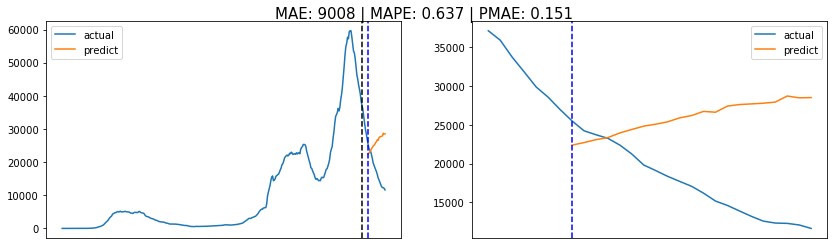

In [161]:
plot_LSTM_niave(ignore_size=60)

### Pre-processing

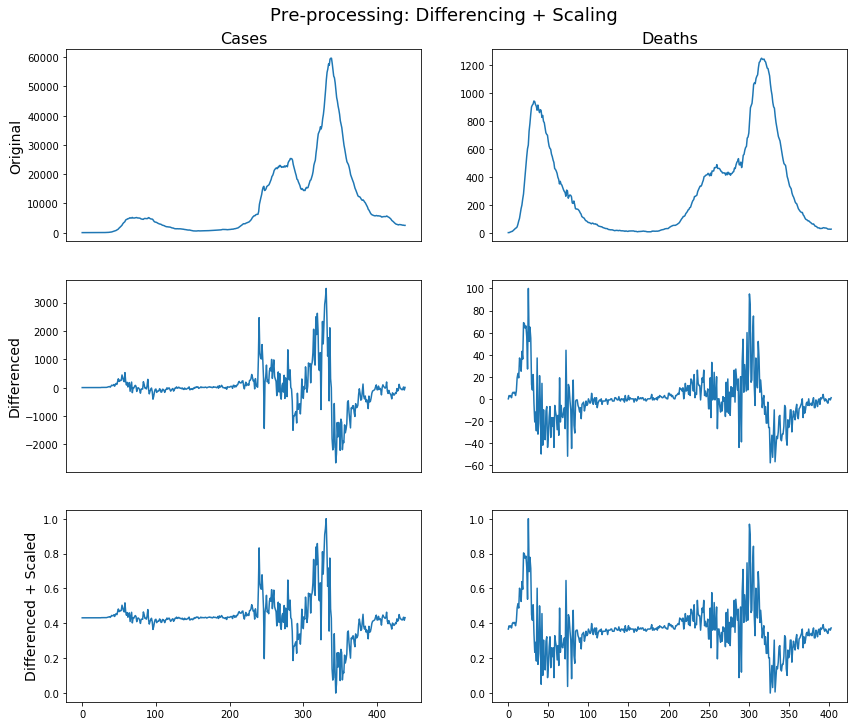

In [523]:
plt.figure(figsize=(14,12))    
ax = plt.subplot(321)
ax.plot(DATA_UK_CASES_LIST)
ax.set_title('Cases', fontsize=16)
ax.set_ylabel('Original', fontsize=14)
ax.set_xticks([])
ax = plt.subplot(322)
ax.plot(DATA_UK_DEATHS_LIST)
ax.set_title('Deaths', fontsize=16)
ax.set_xticks([])
ax = plt.subplot(323)
ax.plot(DATA_UK_CASES_DIFF_LIST)
ax.set_ylabel('Differenced', fontsize=14)
ax.set_xticks([])
ax = plt.subplot(324)
ax.plot(DATA_UK_DEATHS_DIFF_LIST)
ax.set_xticks([])
ax = plt.subplot(325)
ax.plot(DATA_UK_CASES_DIFF_LIST_SCALED)
ax.set_ylabel('Differenced + Scaled', fontsize=14)
ax = plt.subplot(326)
ax.plot(DATA_UK_DEATHS_DIFF_LIST_SCALED)
plt.suptitle('Pre-processing: Differencing + Scaling', y=0.93, fontsize=18)
plt.show()

### Cases | LSTM | Pre-processing: Differencing + Scaling

Epoch 42: early stopping


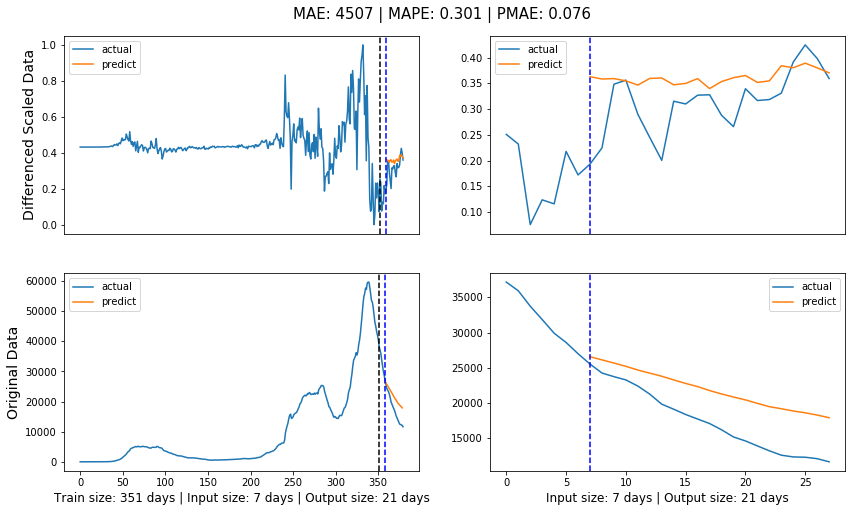

In [160]:
plot_LSTM(ignore_size=60)

### LSTM Model (Multivariant)

In [4]:
def to_sequence(data, features=[], input_size=7, output_size=21):
    x, y, arrs = [], [], [data] + features
    for i in range(len(data)-input_size-output_size+1):
        x.append([[arr[n] for arr in arrs] for n in range(i,i+input_size)])
        y.append(data[i+input_size:i+input_size+output_size])
    return np.array(x), np.array(y)

def get_LSTM(cases=True, features=[], ignore_start_size=0, ignore_size=0, input_size=7, output_size=21):
    data = DATA_UK_CASES_DIFF_LIST_SCALED[ignore_start_size:] if cases else DATA_UK_DEATHS_DIFF_LIST_SCALED[ignore_start_size:]
    data_original = DATA_UK_CASES_LIST[ignore_start_size:] if cases else DATA_UK_DEATHS_LIST[ignore_start_size:]
    
    data_used = data if ignore_size==0 else data[:-ignore_size]
    data_original_used = data_original if ignore_size==0 else data_original[:-ignore_size]
    features_used = [feature if ignore_size==0 else feature[:-ignore_size] for feature in features]
    
    x_train, y_train = to_sequence(data_used[:-output_size-input_size], features_used, input_size, output_size)
    x_test, y_test = to_sequence(data_used[-output_size-input_size:], features_used, input_size, output_size)
    
    model = Sequential([LSTM(128, input_shape=(None,len(features)+1), return_sequences=True), Dropout(0.2), LSTM(64), Dropout(0.2), Dense(128, 'relu'), Dense(64, 'relu'), Dense(output_size)])
    model.compile('adam', 'mse', 'mae')
    
    earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=earlyStopping, epochs=300, verbose=0)
    print(f'Epoch {earlyStopping.stopped_epoch}: early stopping')
    
    train_size = len(data_used[:-output_size-input_size])
    y_pred = get_original(model(x_test).numpy()[0], train_size+input_size, cases)
    y_true = data_original_used[train_size+input_size+1: train_size+input_size+output_size+1]
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    pmae = mae / (max(data_original_used)-min(data_original_used))
    return mae, mape, pmae

def get_LSTM_global(cases=True, feature_time_series=False, feature_stringency=False, feature_vaccination=False, 
                     feature_admissions=False, feature_tests=False, feature_ventilators=False, feature_r0=False, ignore_start_size=0,
                     input_size=7, output_size=21):   
    
    features, features_name = [], ''
    
    if cases:
        data = DATA_UK_CASES_DIFF_LIST_SCALED[ignore_start_size:]
        data_original, data_name = DATA_UK_CASES_LIST[ignore_start_size:], 'Cases'
        ignore_sizes = [0, 20, 30, 60, 87, 98, 128, 150, 160, 175]
        if feature_time_series:
            features.append(FEATURE_DEATHS_FOR_CASES)
            features_name += '+Deaths'
        if feature_stringency:
            features.append(FEATURE_STRINGENCY_FOR_CASES)
            features_name += '+Stringency'
        if feature_vaccination:
            features.append(FEATURE_VACCINATION_FOR_CASES)
            features_name += '+Vaccination'
        if feature_admissions:
            features.append(FEATURE_ADMISSIONS_FOR_CASES)
            features_name += '+Admissions'
        if feature_tests:
            features.append(FEATURE_TESTS_FOR_CASES)
            features_name += '+Tests'
        if feature_ventilators:
            features.append(FEATURE_VENTILATORS_FOR_CASES)
            features_name += '+Ventilators'
        if feature_r0:
            features.append(FEATURE_R0_FOR_CASES)
            features_name += '+R0'
            
    else:
        data = DATA_UK_DEATHS_DIFF_LIST_SCALED[ignore_start_size:]
        data_original, data_name = DATA_UK_DEATHS_LIST[ignore_start_size:], 'Deaths'
        ignore_sizes = [0, 10, 25, 45, 52, 81, 85, 110, 155, 185]
        if feature_time_series:
            features.append(FEATURE_CASES_FOR_DEATHS)
            features_name += '+Cases'
        if feature_stringency:
            features.append(FEATURE_STRINGENCY_FOR_DEATHS)
            features_name += '+Stringency'
        if feature_vaccination:
            features.append(FEATURE_VACCINATION_FOR_DEATHS)
            features_name += '+Vaccination'
        if feature_admissions:
            features.append(FEATURE_ADMISSIONS_FOR_DEATHS)
            features_name += '+Admissions'
        if feature_tests:
            features.append(FEATURE_TESTS_FOR_DEATHS)
            features_name += '+Tests'
        if feature_ventilators:
            features.append(FEATURE_VENTILATORS_FOR_DEATHS)
            features_name += '+Ventilators'
        if feature_r0:
            features.append(FEATURE_R0_FOR_DEATHS)
            features_name += '+R0'
            
    total_size, train_sizes, mae_list, mape_list, pmae_list = len(data), [], [], [], []
    
    for ignore_size in ignore_sizes:
        data_used = data if ignore_size==0 else data[:-ignore_size]        
        data_original_used = data_original if ignore_size==0 else data_original[:-ignore_size]
        features_used = [feature if ignore_size==0 else feature[:-ignore_size] for feature in features]
        
        x_train, y_train = to_sequence(data_used[:-output_size-input_size], features_used, input_size, output_size)
        x_test, y_test = to_sequence(data_used[-output_size-input_size:], features_used, input_size, output_size)

        model = Sequential([LSTM(128, input_shape=(None,len(features)+1)), Dense(128, 'relu'), Dense(output_size)])
        model.compile('adam', 'mse')
        model.fit(x_train, y_train, epochs=100, verbose=0)
        
        train_size = len(data_used[:-output_size-input_size])
        train_sizes.append(train_size)
        
        y_pred = get_original(model(x_test).numpy()[0], train_size+input_size, cases)
        y_true = data_original_used[train_size+input_size+1: train_size+input_size+output_size+1]
        
        mae = mean_absolute_error(y_true, y_pred)
        mae_list.append(mae)
        
        mape = mean_absolute_percentage_error(y_true, y_pred)        
        mape_list.append(mape)
        
        pmae = mae / (max(data_original_used)-min(data_original_used))
        pmae_list.append(pmae)
    
    mae_avg, mape_avg, pmae_avg = sum(mae_list)/len(mae_list), sum(mape_list)/len(mape_list), sum(pmae_list)/len(pmae_list)
    print(f'Data: {data_name} | Features: {data_name}{features_name} \n MAE(average): {round(mae_avg)} | MAPE(average): {mape_avg:.3f} | PMAE(average): {pmae_avg:.3f}')
    
def plot_LSTM(cases=True, features=[], ignore_start_size=0, ignore_size=0, input_size=7, output_size=21):
    data = DATA_UK_CASES_DIFF_LIST_SCALED[ignore_start_size:] if cases else DATA_UK_DEATHS_DIFF_LIST_SCALED[ignore_start_size:]
    data_original = DATA_UK_CASES_LIST[ignore_start_size:] if cases else DATA_UK_DEATHS_LIST[ignore_start_size:]
    
    data_used = data if ignore_size==0 else data[:-ignore_size]
    data_original_used = data_original if ignore_size==0 else data_original[:-ignore_size]
    features_used = [feature if ignore_size==0 else feature[:-ignore_size] for feature in features]
    
    x_train, y_train = to_sequence(data_used[:-output_size-input_size], features_used, input_size, output_size)
    x_test, y_test = to_sequence(data_used[-output_size-input_size:], features_used, input_size, output_size)
    
    model = Sequential([LSTM(128, input_shape=(None,len(features)+1), return_sequences=True), Dropout(0.2), LSTM(64), Dropout(0.2), Dense(128, 'relu'), Dense(64, 'relu'), Dense(output_size)])
    model.compile('adam', 'mse', 'mae')
    
    earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=earlyStopping, epochs=300, verbose=0)
    print(f'Epoch {earlyStopping.stopped_epoch}: early stopping')
    
    train_size = len(data_used[:-output_size-input_size])
    y_pred = get_original(model(x_test).numpy()[0], train_size+input_size, cases)
    y_true = data_original_used[train_size+input_size+1: train_size+input_size+output_size+1]
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    pmae = mae / (max(data_original_used)-min(data_original_used))
    
    plt.figure(figsize=(14,8))    
    plt.suptitle(f'MAE: {round(mae)} | MAPE: {mape:.3f} | PMAE: {pmae:.3f}', y=0.93, fontsize=15)
    
    plt.subplot(221)
    plt.plot(data_used, label='actual')
    plt.plot([n for n in range(train_size+input_size, train_size+output_size+input_size)], model(x_test).numpy()[0], label='predict')
    plt.ylabel('Differenced Scaled Data', fontsize=14)
    plt.axvline(x=train_size, color='black', linestyle='--')
    plt.axvline(x=train_size+input_size, color='b', linestyle='--')
    plt.xticks([])
    plt.legend()
    
    plt.subplot(222)
    plt.plot(data_used[-output_size-input_size:], label='actual')
    plt.plot([n for n in range(input_size, output_size+input_size)], model(x_test).numpy()[0], label='predict')
    plt.axvline(x=input_size, color='b', linestyle='--')
    plt.xticks([])
    plt.legend()

    plt.subplot(223)
    plt.plot(data_original_used, label='actual')
    plt.plot([n for n in range(train_size+input_size, train_size+output_size+input_size)], y_pred, label='predict')
    plt.ylabel('Original Data', fontsize=14)
    plt.axvline(x=train_size, color='black', linestyle='--')
    plt.axvline(x=train_size+input_size, color='b', linestyle='--')
    plt.xlabel(f'Train size: {train_size} days | Input size: {input_size} days | Output size: {output_size} days', fontsize=12)
    plt.legend()
    
    plt.subplot(224)
    plt.plot(data_original_used[-output_size-input_size:], label='actual')
    plt.plot([n for n in range(input_size, output_size+input_size)], y_pred, label='predict')
    plt.axvline(x=input_size, color='b', linestyle='--')
    plt.xlabel(f'Input size: {input_size} days | Output size: {output_size} days', fontsize=12)
    plt.legend()
    
def plot_LSTM_global(cases=True, feature_time_series=False, feature_stringency=False, feature_vaccination=False, 
                     feature_admissions=False, feature_tests=False, feature_ventilators=False, feature_r0=False, ignore_start_size=0,
                     input_size=7, output_size=21):   
    
    features, features_name = [], ''
    
    if cases:
        data = DATA_UK_CASES_DIFF_LIST_SCALED[ignore_start_size:]
        data_original, data_name = DATA_UK_CASES_LIST[ignore_start_size:], 'Cases'
        ignore_sizes = [0, 20, 30, 60, 87, 98, 128, 150, 160, 175]
        if feature_time_series:
            features.append(FEATURE_DEATHS_FOR_CASES)
            features_name += '+Deaths'
        if feature_stringency:
            features.append(FEATURE_STRINGENCY_FOR_CASES)
            features_name += '+Stringency'
        if feature_vaccination:
            features.append(FEATURE_VACCINATION_FOR_CASES)
            features_name += '+Vaccination'
        if feature_admissions:
            features.append(FEATURE_ADMISSIONS_FOR_CASES)
            features_name += '+Admissions'
        if feature_tests:
            features.append(FEATURE_TESTS_FOR_CASES)
            features_name += '+Tests'
        if feature_ventilators:
            features.append(FEATURE_VENTILATORS_FOR_CASES)
            features_name += '+Ventilators'
        if feature_r0:
            features.append(FEATURE_R0_FOR_CASES)
            features_name += '+R0'
            
    else:
        data = DATA_UK_DEATHS_DIFF_LIST_SCALED[ignore_start_size:]
        data_original, data_name = DATA_UK_DEATHS_LIST[ignore_start_size:], 'Deaths'
        ignore_sizes = [0, 10, 25, 45, 52, 81, 85, 110, 155, 185]
        if feature_time_series:
            features.append(FEATURE_CASES_FOR_DEATHS)
            features_name += '+Cases'
        if feature_stringency:
            features.append(FEATURE_STRINGENCY_FOR_DEATHS)
            features_name += '+Stringency'
        if feature_vaccination:
            features.append(FEATURE_VACCINATION_FOR_DEATHS)
            features_name += '+Vaccination'
        if feature_admissions:
            features.append(FEATURE_ADMISSIONS_FOR_DEATHS)
            features_name += '+Admissions'
        if feature_tests:
            features.append(FEATURE_TESTS_FOR_DEATHS)
            features_name += '+Tests'
        if feature_ventilators:
            features.append(FEATURE_VENTILATORS_FOR_DEATHS)
            features_name += '+Ventilators'
        if feature_r0:
            features.append(FEATURE_R0_FOR_DEATHS)
            features_name += '+R0'
            
    variate_name = 'univariate' if features==[] else 'multivariate'

    plt.figure(figsize=(14,8))    
    ax0 = plt.subplot(211)
    ax0.plot(data, label='actual')
    ax0.set_ylabel('Differenced Scaled Data', fontsize=14)
    
    ax1 = plt.subplot(212)
    ax1.plot(data_original, label='actual')
    ax1.set_ylabel('Original Data', fontsize=14)
    
    total_size, train_sizes, mae_list, mape_list, pmae_list = len(data), [], [], [], []
    
    for ignore_size in ignore_sizes:
        data_used = data if ignore_size==0 else data[:-ignore_size]        
        data_original_used = data_original if ignore_size==0 else data_original[:-ignore_size]
        features_used = [feature if ignore_size==0 else feature[:-ignore_size] for feature in features]
        
        x_train, y_train = to_sequence(data_used[:-output_size-input_size], features_used, input_size, output_size)
        x_test, y_test = to_sequence(data_used[-output_size-input_size:], features_used, input_size, output_size)

        model = Sequential([LSTM(128, input_shape=(None,len(features)+1)), Dense(128, 'relu'), Dense(output_size)])
        model.compile('adam', 'mse')
        model.fit(x_train, y_train, epochs=100, verbose=0)
        
        train_size = len(data_used[:-output_size-input_size])
        train_sizes.append(train_size)
        
        y_pred = get_original(model(x_test).numpy()[0], train_size+input_size, cases)
        y_true = data_original_used[train_size+input_size+1: train_size+input_size+output_size+1]
        
        mae = mean_absolute_error(y_true, y_pred)
        mae_list.append(mae)
        
        mape = mean_absolute_percentage_error(y_true, y_pred)        
        mape_list.append(mape)
        
        pmae = mae / (max(data_original_used)-min(data_original_used))
        pmae_list.append(pmae)
        
        if ignore_size==ignore_sizes[0]:
            ax0.plot([n for n in range(total_size-ignore_size-output_size, total_size-ignore_size)], model(x_test).numpy()[0], label='predict', color='C1')
            ax1.plot([n for n in range(total_size-ignore_size-output_size, total_size-ignore_size)], y_pred, label='predict', color='C1')
        else :
            ax0.plot([n for n in range(total_size-ignore_size-output_size, total_size-ignore_size)], model(x_test).numpy()[0], color='C1')
            ax1.plot([n for n in range(total_size-ignore_size-output_size, total_size-ignore_size)], y_pred, color='C1')
    
        ax0.axvline(x=train_size, color='black', linestyle='--')
        ax1.axvline(x=train_size, color='black', linestyle='--')
        ax0.axvline(x=total_size-ignore_size-output_size, color='b', linestyle='--')
        ax1.axvline(x=total_size-ignore_size-output_size, color='b', linestyle='--')
        
    ax0.legend()    
    ax1.legend()
    
    mae_avg, mape_avg, pmae_avg = sum(mae_list)/len(mae_list), sum(mape_list)/len(mape_list), sum(pmae_list)/len(pmae_list)
    plt.suptitle(f'Data: {data_name} | Features({variate_name}): {data_name}{features_name} | \n MAE(average): {round(mae_avg)} | MAPE(average): {mape_avg:.3f} | PMAE(average): {pmae_avg:.3f}', y=0.96, fontsize=15)
    plt.xlabel(f'Train sizes: {train_sizes[::-1]} | Input size: {input_size} | Output size: {output_size} (days)', fontsize=12)

### LSTM Features

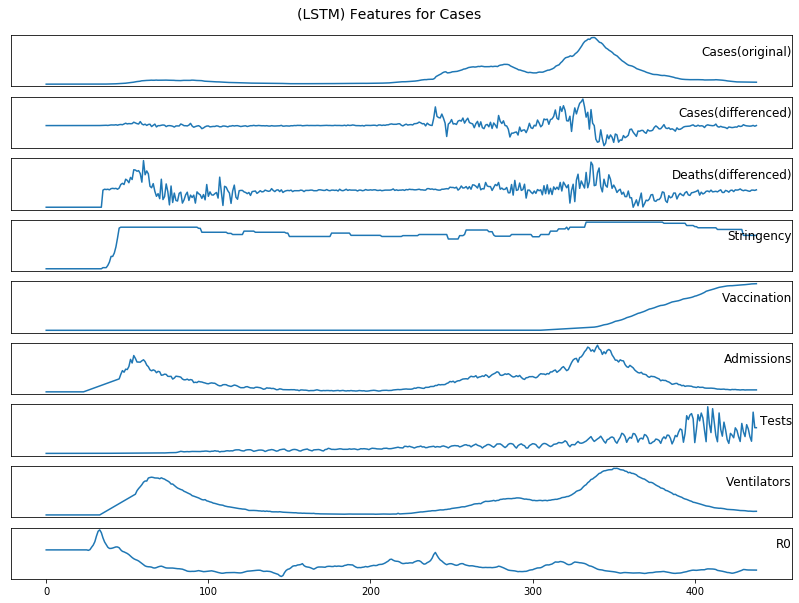

In [44]:
features_cases = [DATA_UK_CASES_LIST, DATA_UK_CASES_DIFF_LIST_SCALED, FEATURE_DEATHS_FOR_CASES, FEATURE_STRINGENCY_FOR_CASES, FEATURE_VACCINATION_FOR_CASES, 
                  FEATURE_ADMISSIONS_FOR_CASES, FEATURE_TESTS_FOR_CASES, FEATURE_VENTILATORS_FOR_CASES, FEATURE_R0_FOR_CASES]

features_names_cases = ['Cases(original)', 'Cases(differenced)', 'Deaths(differenced)', 'Stringency', 'Vaccination', 'Admissions', 'Tests', 'Ventilators', 'R0']
plt.figure(figsize=(14,10))
plt.suptitle('(LSTM) Features for Cases', fontsize=14, y=0.92)
for i in range(9):
    plt.subplot(9,1,i+1)
    plt.plot(features_cases[i])
    plt.title(features_names_cases[i], y=0.5, loc='right')
    plt.yticks([])   
    if i!=8: plt.xticks([])

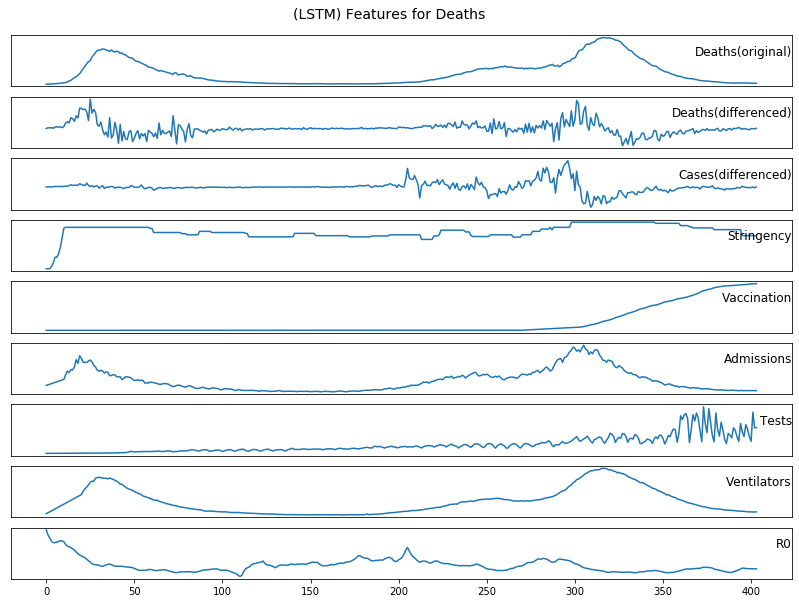

In [5]:
features_deaths = [DATA_UK_DEATHS_LIST, DATA_UK_DEATHS_DIFF_LIST_SCALED, FEATURE_CASES_FOR_DEATHS, FEATURE_STRINGENCY_FOR_DEATHS, FEATURE_VACCINATION_FOR_DEATHS, 
                   FEATURE_ADMISSIONS_FOR_DEATHS, FEATURE_TESTS_FOR_DEATHS, FEATURE_VENTILATORS_FOR_DEATHS, FEATURE_R0_FOR_DEATHS]

features_names_deaths = ['Deaths(original)', 'Deaths(differenced)', 'Cases(differenced)', 'Stringency', 'Vaccination', 'Admissions', 'Tests', 'Ventilators', 'R0']

plt.figure(figsize=(14,10))
plt.suptitle('(LSTM) Features for Deaths', fontsize=14, y=0.92)
for i in range(9):
    plt.subplot(9,1,i+1)
    plt.plot(features_deaths[i])
    plt.title(features_names_deaths[i], y=0.5, loc='right')
    plt.yticks([])   
    if i!=8: plt.xticks([])

### Cases |  LSTM(univariate)

Epoch 55: early stopping


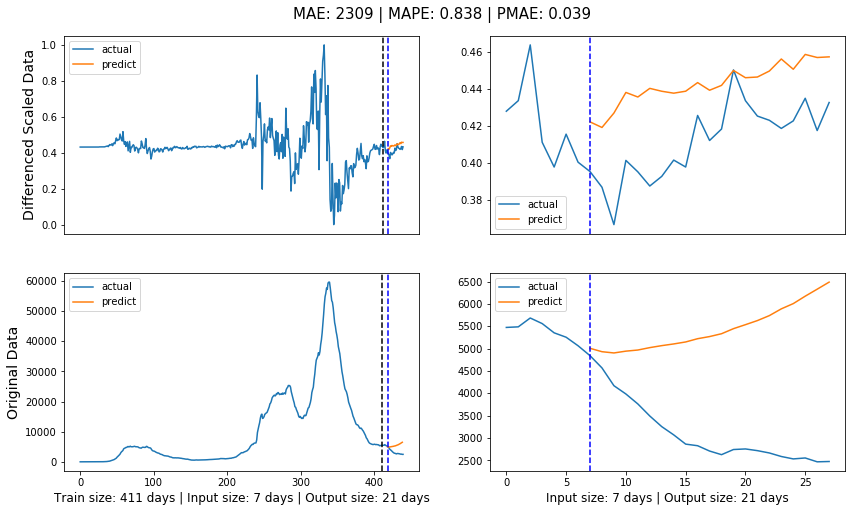

In [65]:
plot_LSTM(True, features=[])

### Cases | LSTM(multivariate): Cases + Stringency + Vaccination

Epoch 122: early stopping


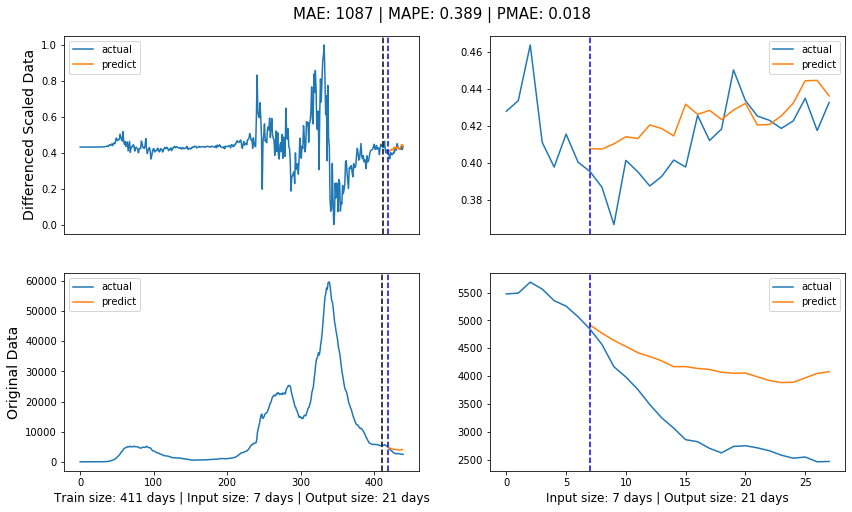

In [76]:
plot_LSTM(True, features=[FEATURE_STRINGENCY_FOR_CASES, FEATURE_VACCINATION_FOR_CASES])

### Cases | LSTM(multivariate): Cases + Stringency 

Epoch 89: early stopping


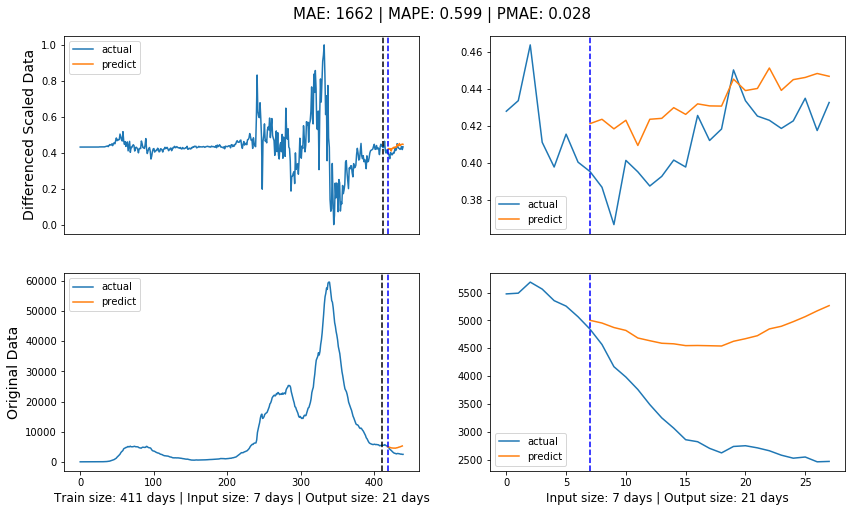

In [87]:
plot_LSTM(True, features=[FEATURE_STRINGENCY_FOR_CASES])

### Cases | LSTM(multivariate): Cases + Vaccination 

Epoch 102: early stopping


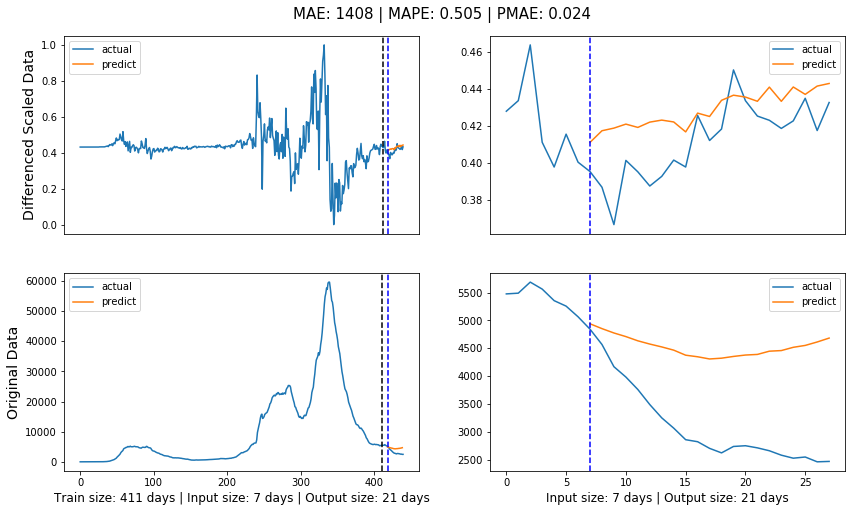

In [88]:
plot_LSTM(True, features=[FEATURE_VACCINATION_FOR_CASES])

### Cases | LSTM(multivariate): Cases + Testing

Epoch 85: early stopping


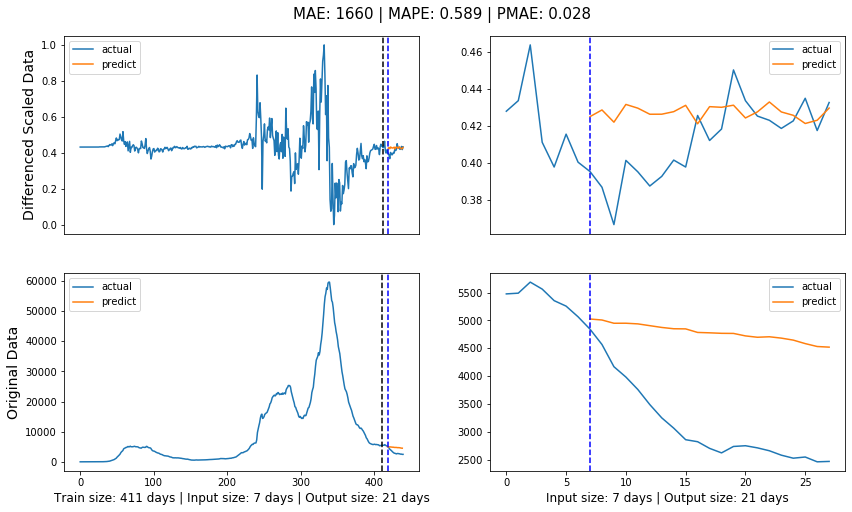

In [260]:
plot_LSTM(True, features=[FEATURE_TESTS_FOR_CASES])

### Cases | LSTM(multivariate): Cases + Stringency + Vaccination + Testing

Epoch 76: early stopping


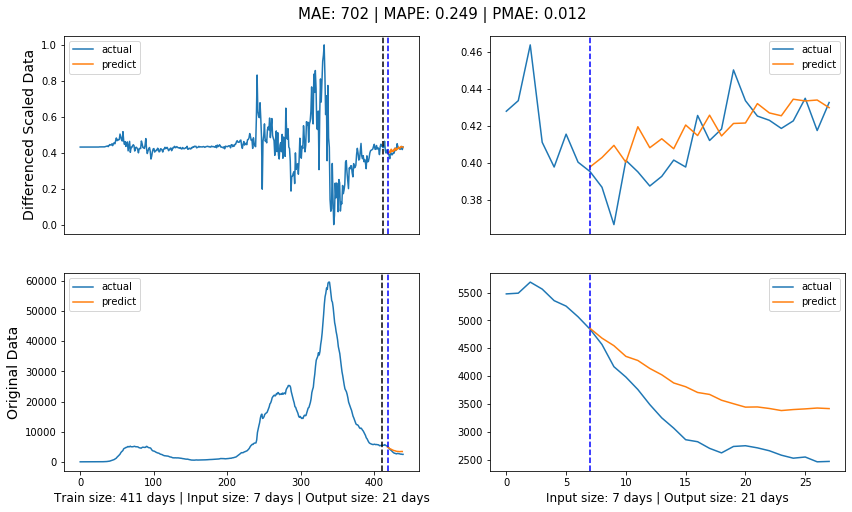

In [259]:
plot_LSTM(True, features=[FEATURE_TESTS_FOR_CASES, FEATURE_STRINGENCY_FOR_CASES, FEATURE_VACCINATION_FOR_CASES])

### CF Values (Cases)

In [316]:
get_LSTM_global(True, True, False, False, False, False, False, False)

Data: Cases | Features: Cases+Deaths 
 MAE(average): 3278 | MAPE(average): 0.198 | PMAE(average): 0.067


In [183]:
get_LSTM_global(True, False, True, False, False, False, False, False)

Data: Cases | Features: Cases+Stringency 
 MAE(average): 2699 | MAPE(average): 0.158 | PMAE(average): 0.057


In [215]:
get_LSTM_global(True, False, False, True, False, False, False, False)

Data: Cases | Features: Cases+Vaccination 
 MAE(average): 2740 | MAPE(average): 0.144 | PMAE(average): 0.059


In [274]:
get_LSTM_global(True, False, False, False, True, False, False, False)

Data: Cases | Features: Cases+Admissions 
 MAE(average): 3263 | MAPE(average): 0.267 | PMAE(average): 0.070


In [268]:
get_LSTM_global(True, False, False, False, False, True, False, False)

Data: Cases | Features: Cases+Tests 
 MAE(average): 2752 | MAPE(average): 0.164 | PMAE(average): 0.058


In [239]:
get_LSTM_global(True, False, False, False, False, False, True, False)

Data: Cases | Features: Cases+Ventilators 
 MAE(average): 3701 | MAPE(average): 0.242 | PMAE(average): 0.078


In [188]:
get_LSTM_global(True, False, False, False, False, False, False, True)

Data: Cases | Features: Cases+R0 
 MAE(average): 3662 | MAPE(average): 0.200 | PMAE(average): 0.077


In [343]:
print_factors([3025, 3278, 2699, 2740, 3263, 2752, 3701, 3662])

Contributing Factors(CF): 
[0.0, -0.084, 0.108, 0.094, -0.079, 0.09, -0.223, -0.211]


### LSTM Results (Cases)

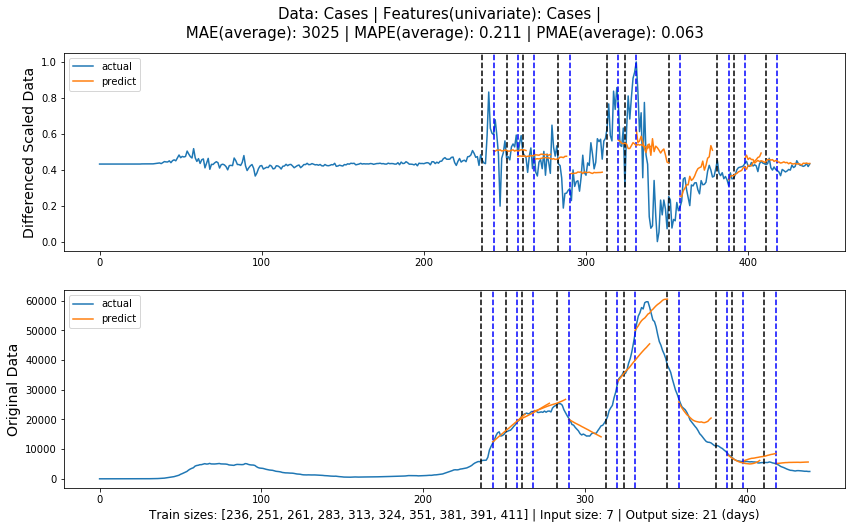

In [327]:
plot_LSTM_global(True, False, False, False, False, False, False, False)

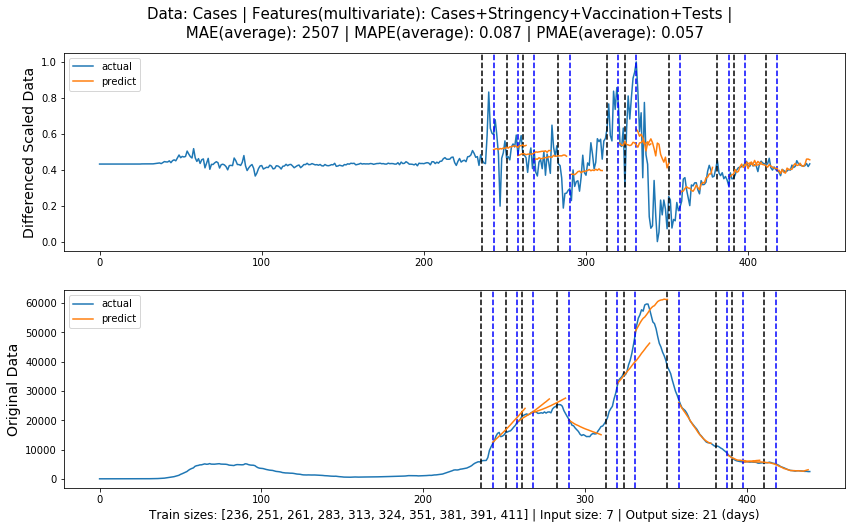

In [250]:
plot_LSTM_global(True, False, True, True, False, True, False, False)

### CF Values (Deaths)

In [190]:
get_LSTM_global(False, True, False, False, False, False, False, False)

Data: Deaths | Features: Deaths+Cases 
 MAE(average): 44 | MAPE(average): 0.341 | PMAE(average): 0.038


In [191]:
get_LSTM_global(False, False, True, False, False, False, False, False)

Data: Deaths | Features: Deaths+Stringency 
 MAE(average): 233 | MAPE(average): 2.444 | PMAE(average): 0.205


In [192]:
get_LSTM_global(False, False, False, True, False, False, False, False)

Data: Deaths | Features: Deaths+Vaccination 
 MAE(average): 62 | MAPE(average): 0.259 | PMAE(average): 0.054


In [193]:
get_LSTM_global(False, False, False, False, True, False, False, False)

Data: Deaths | Features: Deaths+Admissions 
 MAE(average): 88 | MAPE(average): 0.795 | PMAE(average): 0.077


In [194]:
get_LSTM_global(False, False, False, False, False, True, False, False)

Data: Deaths | Features: Deaths+Tests 
 MAE(average): 106 | MAPE(average): 0.601 | PMAE(average): 0.096


In [195]:
get_LSTM_global(False, False, False, False, False, False, True, False)

Data: Deaths | Features: Deaths+Ventilators 
 MAE(average): 92 | MAPE(average): 0.741 | PMAE(average): 0.081


In [196]:
get_LSTM_global(False, False, False, False, False, False, False, True)

Data: Deaths | Features: Deaths+R0 
 MAE(average): 359 | MAPE(average): 3.311 | PMAE(average): 0.317


In [344]:
print_factors([70, 44, 233, 62, 88, 106, 92, 359])

Contributing Factors(CF): 
[0.0, 0.371, -2.329, 0.114, -0.257, -0.514, -0.314, -4.129]


### LSTM Results (Deaths)

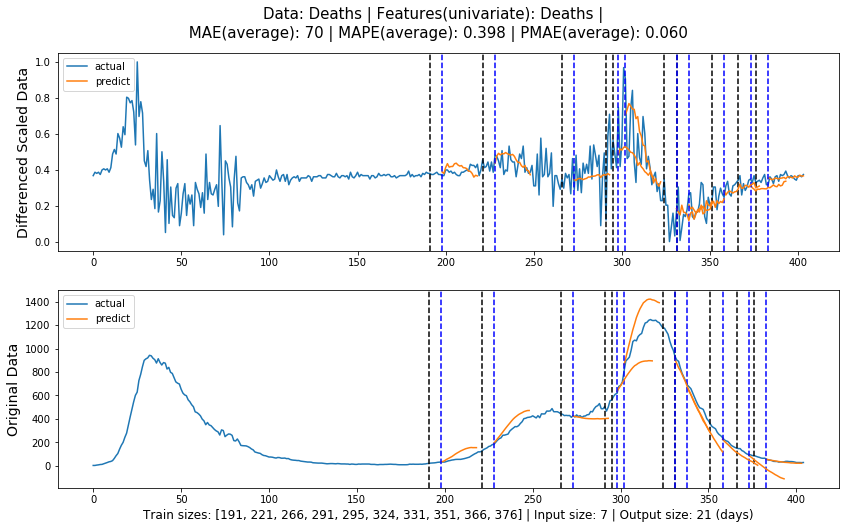

In [311]:
plot_LSTM_global(False, False, False, False, False, False, False, False)

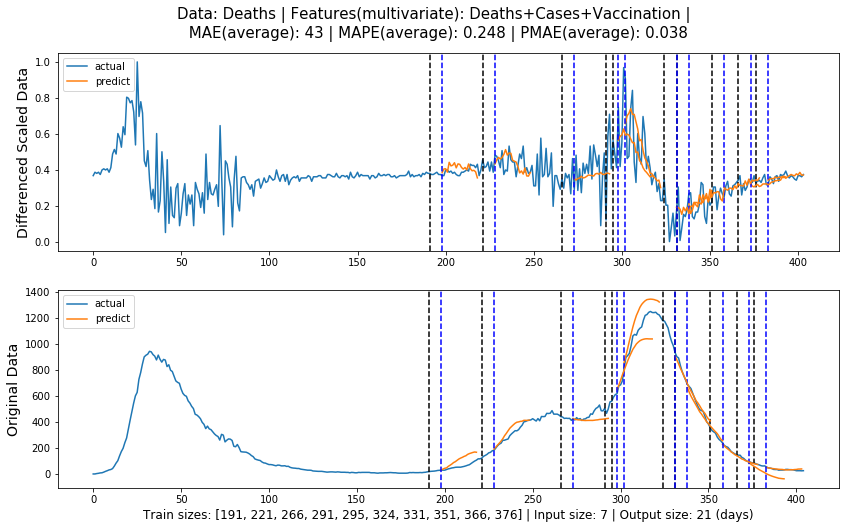

In [308]:
plot_LSTM_global(False, True, False, True, False, False, False, False)

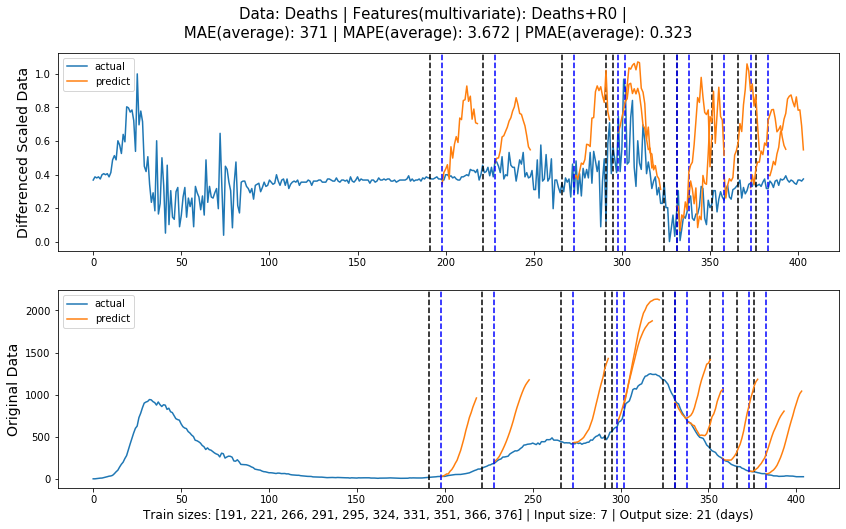

In [524]:
plot_LSTM_global(False, False, False, False, False, False, False, True)

### ARIMA Model

In [29]:
def plot_ARIMA(cases=True, ignore_size=0):
    data = DATA_UK_CASES_LIST if cases else DATA_UK_DEATHS_LIST
    data_used = data if ignore_size==0 else data[:-ignore_size]
        
    model = auto_arima(data_used[:-21], seasonal=False, test='adf', information_criterion='bic',
                       error_action='ignore', suppress_warnings=True, njob=-1) 
    y_pred, y_true = model.predict(21), data_used[-21:]
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    pmae = mae / (max(data_used)-min(data_used))
    
    train_size = len(data_used) - 21
    
    plt.figure(figsize=(14,4))    
    plt.suptitle(f'ARIMA {model.order} | MAE: {round(mae)} | MAPE: {mape:.3f} | PMAE: {pmae:.3f}', y=0.95, fontsize=15)
    
    plt.subplot(121)
    plt.plot(data_used, label='actual')
    plt.plot([n for n in range(train_size, len(data_used))], y_pred, label='predict')
    plt.axvline(x=train_size, color='b', linestyle='--')
    plt.xlabel(f'Train size: {train_size} days | Output size: {21} days', fontsize=12)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(y_true, label='actual')
    plt.plot(y_pred, label='predict')
    plt.axvline(x=0, color='b', linestyle='--')
    plt.xlabel(f'Output size: {21} days', fontsize=12)
    plt.legend()
    
def plot_ARIMA_global(cases=True, additional=False):
    if cases:
        data, data_name = DATA_UK_CASES_LIST, 'Cases'
        if additional:
            ignore_sizes = [0, 20, 30, 60, 87, 98, 128, 150, 160, 175, 200, 225, 250, 275, 300, 325, 350]
        else:
            ignore_sizes = [0, 20, 30, 60, 87, 98, 128, 150, 160, 175]
    else:
        data, data_name = DATA_UK_DEATHS_LIST, 'Deaths'
        if additional:
            ignore_sizes = [0, 10, 25, 45, 52, 81, 85, 110, 155, 185, 200, 225, 250, 275, 300, 325, 350]
        else:
            ignore_sizes = [0, 10, 25, 45, 52, 81, 85, 110, 155, 185]
    
    total_size, train_sizes, mae_list, mape_list, pmae_list, orders = len(data), [], [], [], [], []
    
    plt.figure(figsize=(14,4))    
    plt.plot(data, label='actual')
    
    for ignore_size in ignore_sizes:
        data_used = data if ignore_size==0 else data[:-ignore_size]
        
        model = auto_arima(data_used[:-21], seasonal=False, test='adf', information_criterion='bic',
                           error_action='ignore', suppress_warnings=True, njob=-1) 
        y_pred, y_true = model.predict(21), data_used[-21:]
        
        train_size = len(data_used) - 21
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        pmae = mae / (max(data_used)-min(data_used))
        
        train_sizes.append(train_size)
        mae_list.append(mae)
        mape_list.append(mape)
        pmae_list.append(pmae)
        orders.append(model.order)
        
        if ignore_size==ignore_sizes[0]:
            plt.plot([n for n in range(train_size, len(data_used))], y_pred, label='predict', color='C1')
        else:
            plt.plot([n for n in range(train_size, len(data_used))], y_pred, color='C1')
        
        plt.axvline(x=train_size, color='b', linestyle='--')
        
    mae_avg, mape_avg, pmae_avg = sum(mae_list)/len(mae_list), sum(mape_list)/len(mape_list), sum(pmae_list)/len(pmae_list)
    print(f'ARIMA orders: {orders}')
    plt.suptitle(f'ARIMA | Data: {data_name} | MAE(average): {round(mae_avg)} | MAPE(average): {mape_avg:.3f} | PMAE(average): {pmae_avg:.3f}', y=0.96, fontsize=15)
    plt.xlabel(f'Train sizes: {train_sizes[::-1]} | Output size: {21} (days)', fontsize=12)   
    plt.legend()

### ARIMA Results

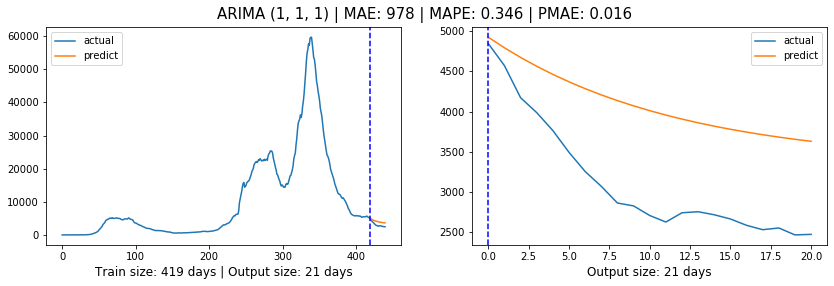

In [14]:
plot_ARIMA()

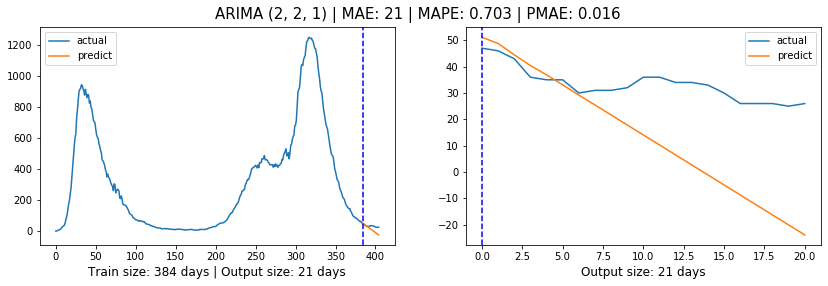

In [20]:
plot_ARIMA(False)

ARIMA orders: [(1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (0, 2, 2), (1, 1, 1), (1, 1, 1), (1, 1, 0), (1, 1, 0), (1, 2, 2)]


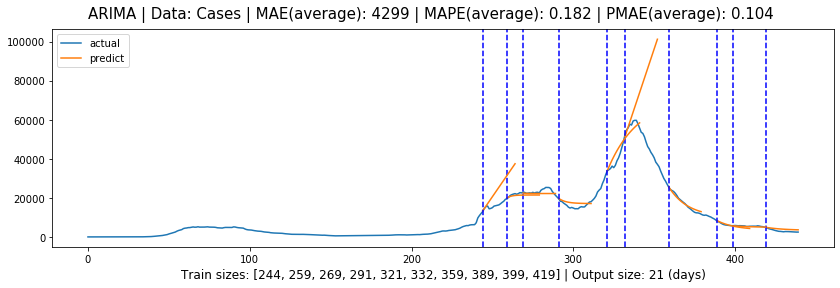

In [22]:
plot_ARIMA_global()

ARIMA orders: [(2, 2, 1), (2, 2, 1), (2, 2, 1), (2, 0, 3), (2, 0, 3), (2, 2, 0), (1, 1, 2), (4, 0, 4), (4, 0, 5), (3, 0, 5)]


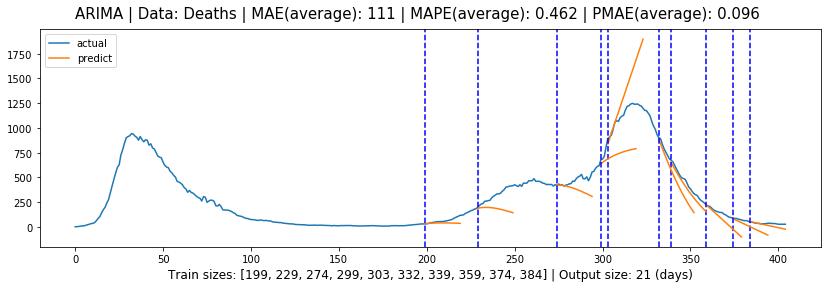

In [23]:
plot_ARIMA_global(False)

ARIMA orders: [(1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (0, 2, 2), (1, 1, 1), (1, 1, 1), (1, 1, 0), (1, 1, 0), (1, 2, 2), (0, 2, 3), (0, 2, 3), (0, 2, 3), (0, 2, 3), (0, 2, 3), (0, 2, 1), (2, 2, 0)]


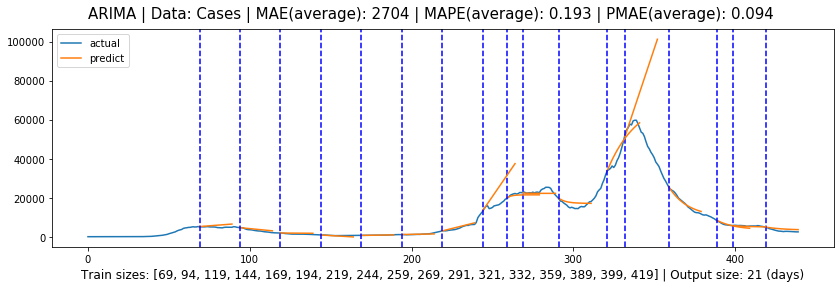

In [30]:
plot_ARIMA_global(True, True)

ARIMA orders: [(2, 2, 1), (2, 2, 1), (2, 2, 1), (2, 0, 3), (2, 0, 3), (2, 2, 0), (1, 1, 2), (4, 0, 4), (4, 0, 5), (3, 0, 5), (3, 0, 5), (3, 0, 5), (2, 0, 3), (0, 2, 3), (0, 2, 3), (0, 2, 2), (1, 2, 0)]


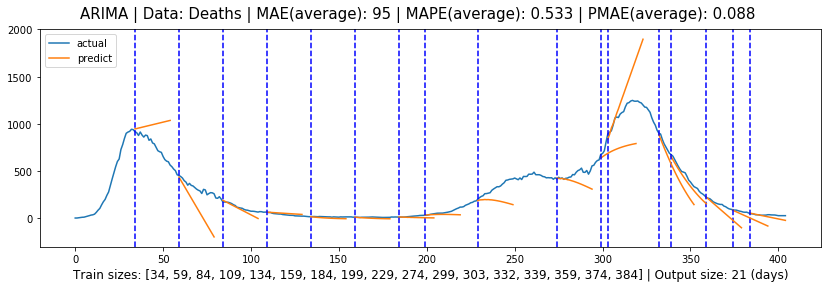

In [26]:
plot_ARIMA_global(False, True)

### Baseline Model

In [37]:
def plot_Baseline_global(cases=True):
    if cases:
        data, data_name = DATA_UK_CASES_LIST, 'Cases'
        ignore_sizes = [0, 20, 30, 60, 87, 98, 128, 150, 160, 175]
    else:
        data, data_name = DATA_UK_DEATHS_LIST, 'Deaths'
        ignore_sizes = [0, 10, 25, 45, 52, 81, 85, 110, 155, 185]
    
    total_size, train_sizes, mae_list, mape_list, pmae_list = len(data), [], [], [], []
    
    plt.figure(figsize=(14,4))    
    plt.plot(data, label='actual')
    
    for ignore_size in ignore_sizes:
        data_used = data if ignore_size==0 else data[:-ignore_size]
        
        y_pred, y_true = [data_used[-21] for n in range(21)], data_used[-21:]
        
        train_size = len(data_used) - 21
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        pmae = mae / (max(data_used)-min(data_used))
        
        train_sizes.append(train_size)
        mae_list.append(mae)
        mape_list.append(mape)
        pmae_list.append(pmae)
        
        if ignore_size==ignore_sizes[0]:
            plt.plot([n for n in range(train_size, len(data_used))], y_pred, label='predict', color='C1')
        else:
            plt.plot([n for n in range(train_size, len(data_used))], y_pred, color='C1')
        
        plt.axvline(x=train_size, color='b', linestyle='--')
        
    mae_avg, mape_avg, pmae_avg = sum(mae_list)/len(mae_list), sum(mape_list)/len(mape_list), sum(pmae_list)/len(pmae_list)
    plt.suptitle(f'Baseline | Data: {data_name} | MAE(average): {round(mae_avg)} | MAPE(average): {mape_avg:.3f} | PMAE(average): {pmae_avg:.3f}', y=0.96, fontsize=15)
    plt.xlabel(f'Train sizes: {train_sizes[::-1]} | Output size: {21} (days)', fontsize=12)   
    plt.legend()

### Baseline Results

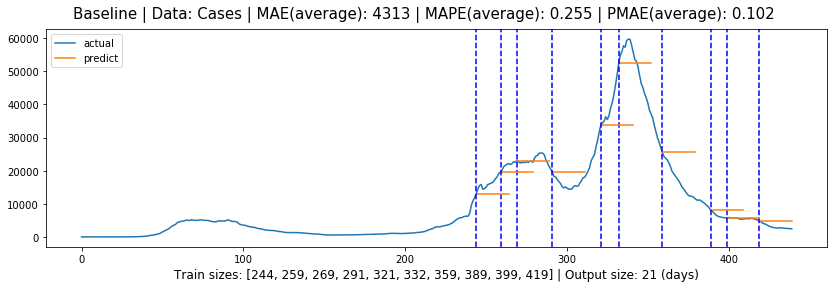

In [40]:
plot_Baseline_global()

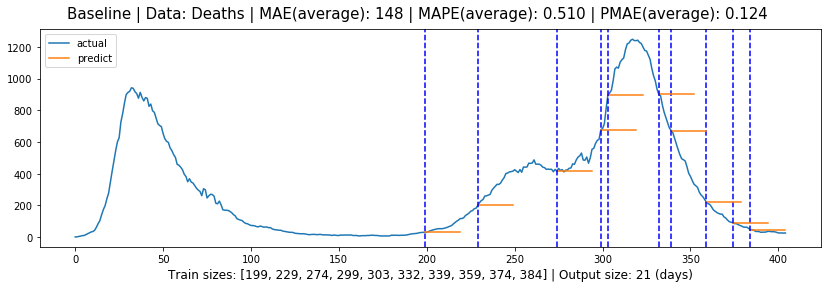

In [39]:
plot_Baseline_global(False)

### LSTM Optimisation

In [5]:
def get_LSTM_history(cases=True, features=[], ignore_start_size=0, ignore_size=0, input_size=7, output_size=21):
    data = DATA_UK_CASES_DIFF_LIST_SCALED[ignore_start_size:] if cases else DATA_UK_DEATHS_DIFF_LIST_SCALED[ignore_start_size:]
    data_original = DATA_UK_CASES_LIST[ignore_start_size:] if cases else DATA_UK_DEATHS_LIST[ignore_start_size:]
    
    data_used = data if ignore_size==0 else data[:-ignore_size]
    data_original_used = data_original if ignore_size==0 else data_original[:-ignore_size]
    features_used = [feature if ignore_size==0 else feature[:-ignore_size] for feature in features]
    
    x_train, y_train = to_sequence(data_used[:-output_size-input_size], features_used, input_size, output_size)
    x_test, y_test = to_sequence(data_used[-output_size-input_size:], features_used, input_size, output_size)
    
    model = Sequential([LSTM(128, input_shape=(None,len(features)+1), return_sequences=True), Dropout(0.2), LSTM(64), Dropout(0.2), Dense(128, 'relu'), Dense(64, 'relu'), Dense(output_size)])
    model.compile('adam', 'mse', 'mae')
    
    earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=earlyStopping, epochs=300, verbose=0)
    print(f'Epoch {earlyStopping.stopped_epoch}: early stopping')
    
    train_size = len(data_used[:-output_size-input_size])
    y_pred = get_original(model(x_test).numpy()[0], train_size+input_size, cases)
    y_true = data_original_used[train_size+input_size+1: train_size+input_size+output_size+1]
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    pmae = mae / (max(data_original_used)-min(data_original_used))
    return history, model

Epoch 112: early stopping


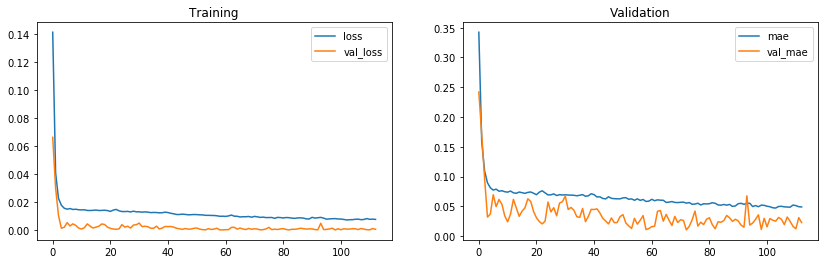

In [8]:
history, model = get_LSTM_history(True, features=[FEATURE_TESTS_FOR_CASES, FEATURE_STRINGENCY_FOR_CASES, FEATURE_VACCINATION_FOR_CASES])
plot_history(history)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         68096     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1

### Visualisation (World Page)

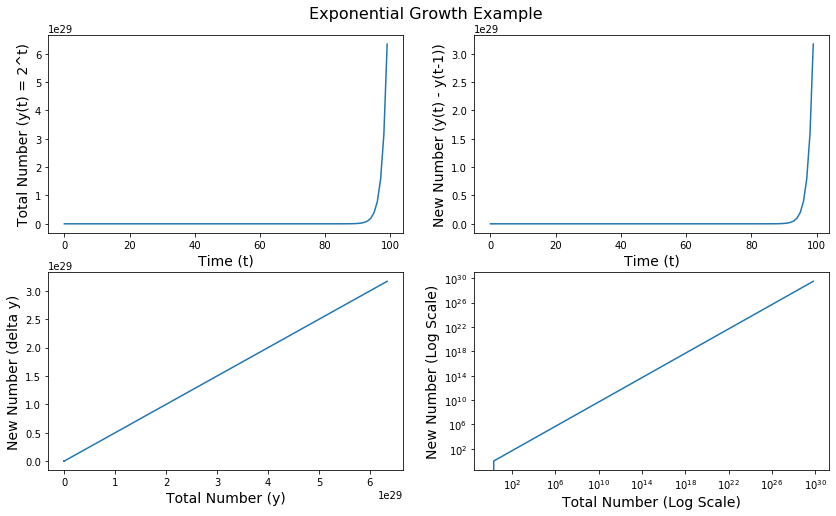

In [494]:
x = [n for n in range(100)]
y = [2**n for n in x]
delta_y = [0] + [y[n+1]-y[n] for n in range(99)]

plt.figure(figsize=(14,8))   
plt.suptitle('Exponential Growth Example', y=0.93, fontsize=16)
ax0 = plt.subplot(221)
ax0.plot(y)
ax0.set_xlabel('Time (t)', fontsize=14)
ax0.set_ylabel('Total Number (y(t) = 2^t)', fontsize=14)

ax1 = plt.subplot(222)
ax1.plot(delta_y)
ax1.set_xlabel('Time (t)', fontsize=14)
ax1.set_ylabel('New Number (y(t) - y(t-1))', fontsize=14)

ax2 = plt.subplot(223)
ax2.plot(y, delta_y)
ax2.set_xlabel('Total Number (y)', fontsize=14)
ax2.set_ylabel('New Number (delta y)', fontsize=14)

ax3 = plt.subplot(224)
ax3.plot(y, delta_y)
ax3.set_xlabel('Total Number (Log Scale)', fontsize=14)
ax3.set_ylabel('New Number (Log Scale)', fontsize=14)
ax3.set_xscale('log')
ax3.set_yscale('log')

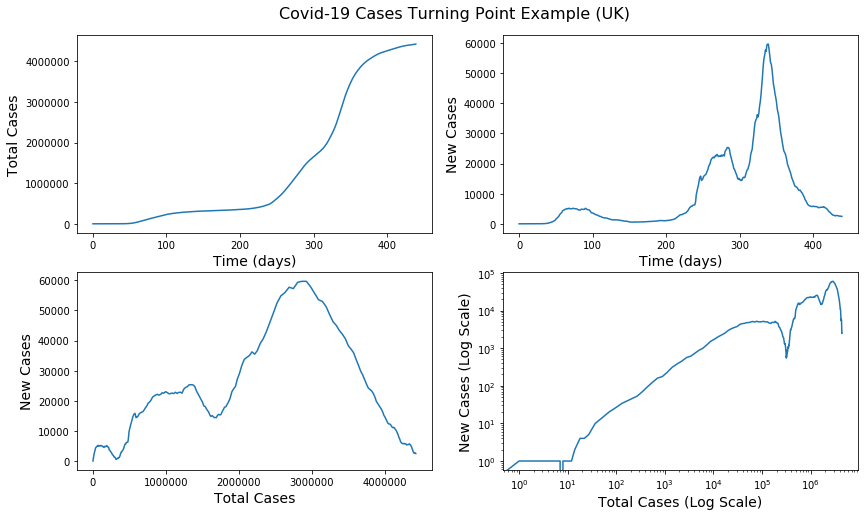

In [496]:
delta_y = DATA_UK_CASES_LIST
y = np.cumsum(DATA_UK_CASES_LIST)

plt.figure(figsize=(14,8))   
plt.suptitle('Covid-19 Cases Turning Point Example (UK)', y=0.93, fontsize=16)
ax0 = plt.subplot(221)
ax0.plot(y)
ax0.set_xlabel('Time (days)', fontsize=14)
ax0.set_ylabel('Total Cases', fontsize=14)

ax1 = plt.subplot(222)
ax1.plot(delta_y)
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('New Cases', fontsize=14)

ax2 = plt.subplot(223)
ax2.plot(y, delta_y)
ax2.set_xlabel('Total Cases', fontsize=14)
ax2.set_ylabel('New Cases', fontsize=14)

ax3 = plt.subplot(224)
ax3.plot(y, delta_y)
ax3.set_xlabel('Total Cases (Log Scale)', fontsize=14)
ax3.set_ylabel('New Cases (Log Scale)', fontsize=14)
ax3.set_xscale('log')
ax3.set_yscale('log')